# Import statements

In [156]:
# from paper: https://cs.stanford.edu/~matei/papers/2020/dispa_cloud_ml.pdf
# to run: clone https://github.com/stanford-futuredata/training_on_a_dime
# replace notebooks/gcp.ipynb with this notebook

!pip install seaborn
!pip install sklearn
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [157]:
import utils
import scipy.integrate as integr
from sklearn.metrics import mean_squared_error

# Print percentage of time an instance can be spun up

In [158]:
def get_availabilities(per_instance_type_spot_prices):
    # Iterate through logs and determine the fraction of time an instance can be spun up.
    total_time_slots = 0
    for instance_type in per_instance_type_spot_prices:
        availability_zones = [x[0] for x in per_instance_type_spot_prices[instance_type]]
        for availability_zone in set(availability_zones):
            timestamps = [matplotlib.dates.date2num(x[2])
                          for x in per_instance_type_spot_prices[instance_type]
                          if x[0] == availability_zone]
            if len(timestamps) > total_time_slots:
                total_time_slots = len(timestamps)
    for instance_type in per_instance_type_spot_prices:
        availability_zones = [x[0] for x in per_instance_type_spot_prices[instance_type]]
        for availability_zone in set(availability_zones):
            timestamps = [matplotlib.dates.date2num(x[2])
                          for x in per_instance_type_spot_prices[instance_type]
                          if x[0] == availability_zone]
            availability = (len(timestamps) / total_time_slots) * 100.00
            print("%s\t%s\t%.2f%%" % (instance_type, availability_zone, availability))

In [159]:
get_availabilities(utils.read_gcp_prices("../logs/gcp/spin_up_and_shut_down"))

('nvidia-tesla-v100', 1)	us-west1-b	93.94%
('nvidia-tesla-v100', 1)	us-west1-a	93.94%
('nvidia-tesla-v100', 1)	us-central1-c	90.91%
('nvidia-tesla-v100', 2)	us-west1-b	100.00%
('nvidia-tesla-v100', 2)	us-west1-a	93.94%
('nvidia-tesla-v100', 2)	us-central1-c	84.85%
('nvidia-tesla-v100', 4)	us-west1-b	100.00%
('nvidia-tesla-v100', 4)	us-west1-a	93.94%
('nvidia-tesla-v100', 4)	us-central1-c	96.97%
('nvidia-tesla-v100', 8)	us-west1-b	100.00%
('nvidia-tesla-v100', 8)	us-west1-a	96.97%
('nvidia-tesla-v100', 8)	us-central1-c	96.97%
('nvidia-tesla-p100', 2)	us-east1-c	78.79%
('nvidia-tesla-p100', 2)	us-west1-b	96.97%
('nvidia-tesla-p100', 2)	us-west1-a	81.82%
('nvidia-tesla-p100', 2)	us-central1-c	93.94%
('nvidia-tesla-p100', 4)	us-east1-c	96.97%
('nvidia-tesla-p100', 4)	us-west1-b	100.00%
('nvidia-tesla-p100', 4)	us-west1-a	96.97%
('nvidia-tesla-p100', 4)	us-central1-c	96.97%
('nvidia-tesla-k80', 1)	us-east1-c	78.79%
('nvidia-tesla-k80', 1)	us-west1-b	57.58%
('nvidia-tesla-k80', 1)	us-central

# Parse and plot availability timelines

In [160]:
import os
from datetime import datetime

def read_persistent_log_files(directory):
    all_events = {}
    instances = {}
    for filename in os.listdir(directory):
        events = {}
        full_filepath = os.path.join(directory, filename)
        if not filename.startswith("persistent_"):
            continue
        with open(full_filepath, 'r') as f:
            # Go through logfile and determine how long preemptible instance requests last.
            for line in f:
                line = line.strip()
                regexes = [
                    r'\[(.*)\] Created instance (.*) with (\d+) GPU\(s\) of type (.*) in zone (.*)',
                    r'\[(.*)\] Instance (.*) not running in zone (.*)',
                ]
                if re.search(regexes[0], line):
                    # Instance spun up.
                    m = re.search(regexes[0], line)
                    timestamp = datetime.strptime(m.group(1),
                                                  '%Y-%m-%dT%H:%M:%S.000Z')
                    instance_name = m.group(2)
                    num_gpus = int(m.group(3))
                    gpu_type = m.group(4)
                    zone = m.group(5)
                    if instance_name not in events:
                        events[instance_name] = []
                    events[instance_name].append([timestamp, None])
                    instances[instance_name] = (num_gpus, gpu_type, zone)
                elif re.search(regexes[1], line):
                    # Instance not running any more; mark as end timestamp.
                    m = re.search(regexes[1], line)
                    timestamp = datetime.strptime(m.group(1),
                                                  '%Y-%m-%dT%H:%M:%S.000Z')
                    instance_name = m.group(2)
                    zone = m.group(3)
                    if instance_name in events and events[instance_name][-1][1] is None:
                        events[instance_name][-1][1] = timestamp
        for instance_name in events:
            if events[instance_name][-1][1] is None:
                events[instance_name][-1][1] = timestamp
        all_events[filename] = events
    return all_events, instances

In [161]:
def plot_timeline(all_events, instances,
                  output_directory=None):
    gpu_type_mapping = {
        "nvidia-tesla-k80": "K80",
        "nvidia-tesla-p100": "P100",
        "nvidia-tesla-v100": "V100",
    }

    for filename, events in all_events.items():        
        all_timestamps = []
        for instance_type in events:
            all_timestamps.extend(
                [x[0] for x in events[instance_type]])
        all_timestamps.sort()

        instance_names = list(events.keys())
        instance_names.sort(key=lambda x: instances[x])
        num_instances = 0
        for instance_name in instance_names:
            if len(events[instance_name]) > 0:
                num_instances += 1
        
        plt.figure(figsize=(10, (0.7 * num_instances) - 0.5))
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

        worker_id_to_type_mapping = {}
        instance_id = 0
        for instance_name in instance_names:
            first_timestamp = events[instance_name][0][0]
            if len(events[instance_name]) > 0:
                # Each event has a start and end timestmap. Draw a line with two vertical
                # markers: one at start and one at end.
                for [start_timestamp, end_timestamp] in events[instance_name]:
                    ax.plot([(start_timestamp - first_timestamp).total_seconds() / (24 * 3600),
                             (end_timestamp - first_timestamp).total_seconds() / (24 * 3600)],
                            [instance_id, instance_id],
                            linewidth=5, c="C%d" % (instance_id % 10),
                            marker='|', markersize=22)
                instance_id += 1

        ax.set_yticks(list(range(len(instance_names))))
        ax.set_yticklabels(["%dx%s, %s" % (
            instances[x][0], gpu_type_mapping[instances[x][1]], instances[x][2])
            for x in instance_names])
        ax.set_xlabel("Time (days)")
        ax.set_ylabel("Instance")
        ax.set_xlim([0, 2.2])

        sns.despine()

        if output_directory is not None:
            output_filename = os.path.join(output_directory,
                                           filename.replace(".out", ".pdf"))
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')

        plt.show()

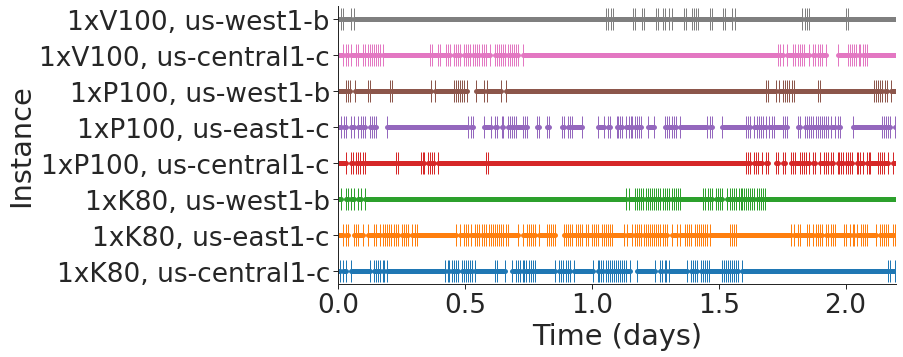

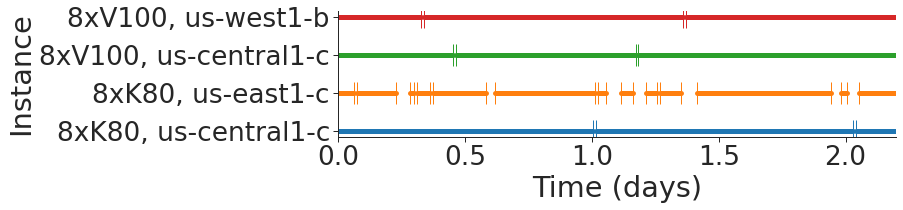

In [162]:
plot_timeline(*read_persistent_log_files("../logs/gcp/availability"),
              output_directory="../graphs/gcp/availability")

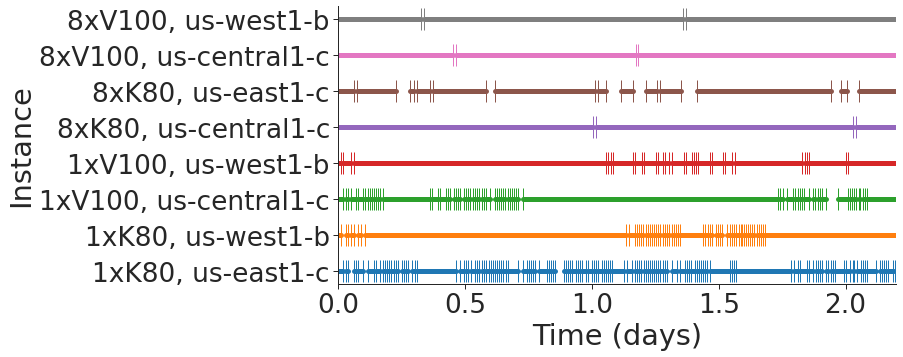

In [163]:
all_events, instances = read_persistent_log_files("../logs/gcp/availability")
aggregated_events = {"aggregate.out": {}}
for filename in all_events:
    for instance in ['instance9', 'instance15', 'instance17', 'instance14', 'instance0', 'instance2', 'instance5', 'instance6']:
        if instance in all_events[filename]:
            aggregated_events["aggregate.out"][instance] = all_events[filename][instance]

plot_timeline(aggregated_events, instances,
              output_directory="../graphs/gcp/availability")

In [164]:
def plot_cdf(all_events, instances):
    # Plot a CDF of preemptible instance durations.
    #print(instances)
    gpu_type_mapping = {
        "nvidia-tesla-k80": "K80",
        "nvidia-tesla-p100": "P100",
        "nvidia-tesla-v100": "V100",
    }

    for filename, events in all_events.items():
        plt.figure(figsize=(11, 3.5))
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

        worker_id_to_type_mapping = {}
        instance_names = list(events.keys())
        instance_names.sort()
        #print(instance_names)
        for instance_name in instance_names:
            if (instances[instance_name][1] == 'nvidia-tesla-p100'):
                durations = []
                for [start_timestamp, end_timestamp] in events[instance_name]:
                    durations.append((end_timestamp - start_timestamp).total_seconds() / 3600)
                durations.sort()
                y_labels = [(i+1) * 100.0 / len(durations) for i in range(len(durations))]
                print(instances[instance_name][1], instances[instance_name][2], durations[len(durations)//2], len(durations))
                ax.plot(durations, y_labels, label="%dx%s, %s" % (
                    instances[instance_name][0],
                    gpu_type_mapping[instances[instance_name][1]],
                    instances[instance_name][2]),
                    linewidth=3
                )

        ax.set_xlabel("Duration (hours)")
        ax.set_ylabel("CDF (%)")
        ax.set_xlim([0, None])
        ax.set_ylim([0, 100])

        leg = plt.figlegend(ncol=3, frameon=False, labelspacing=0.25,
                            columnspacing=0.8, handlelength=1.0,
                            loc='upper center', bbox_to_anchor=(0.65, 1.2))

        
        '''
        bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
        y_offset = 0.65
        bb.y0 += y_offset
        bb.y1 += y_offset
        leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
        
        sns.despine()
        '''
        plt.show()

nvidia-tesla-p100 us-west1-b 0.4102777777777778 27
nvidia-tesla-p100 us-east1-c 0.20527777777777778 73
nvidia-tesla-p100 us-central1-c 0.19833333333333333 49


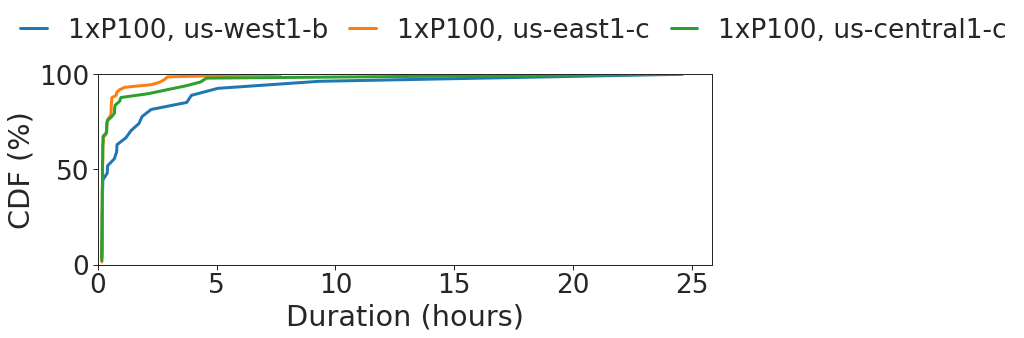

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


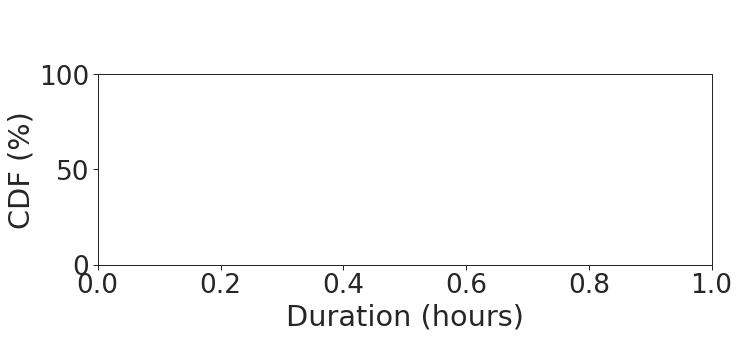

In [138]:
plot_cdf(*read_persistent_log_files("../logs/gcp/availability"))

# Print cost reduction from on-demand to spot

In [126]:
spot_prices = utils.read_gcp_prices("../logs/gcp/spin_up_and_shut_down")
on_demand_prices = {('nvidia-tesla-v100', 1): 2.85, ('nvidia-tesla-p100', 1): 1.68,
                    ('nvidia-tesla-k80', 1): 0.52}
region = 'us-west1-b'
for instance_type in on_demand_prices:
    spot_prices_for_instance_type = spot_prices[instance_type]
    spot_price = None
    for x in spot_prices_for_instance_type:
        if x[0] == region:
            spot_price = float(x[1].replace("$", ""))
            break
    print(instance_type, "%.2f" % (on_demand_prices[instance_type] / spot_price))

('nvidia-tesla-v100', 1) 3.35
('nvidia-tesla-p100', 1) 3.40
('nvidia-tesla-k80', 1) 3.35


In [145]:
## fit distribution
## start with exponential

def func_exp(x, A, l):
    return A * (1 - np.exp(-l*x))

def pdf(x, A, l):
    return A*l*np.exp(-l*x)

def func_exp_cdf(x, A, l):
     integral = integr.quad(pdf, 0, 25, args=(A, l))[0]
     penalization = abs(1.-integral)*10000
     return A * (1 - np.exp(-l*x)) + penalization

def comp_mse(x, y):
    return mean_squared_error(x, y)
    

In [146]:
## get data
def get_data(all_events, instances, gpu_type, zone):
    gpu_type_mapping = {
        "nvidia-tesla-k80": "K80",
        "nvidia-tesla-p100": "P100",
        "nvidia-tesla-v100": "V100",
    }

    for filename, events in all_events.items():
    
        worker_id_to_type_mapping = {}
        instance_names = list(events.keys())
        instance_names.sort()
        #print(instance_names)
        durations = []
        y_labels = []
        for instance_name in instance_names:
            if (instances[instance_name][1] == gpu_type and instances[instance_name][2] == zone):
                for [start_timestamp, end_timestamp] in events[instance_name]:
                    durations.append((end_timestamp - start_timestamp).total_seconds() / 3600)
                durations.sort()
                y_labels = [(i+1) / len(durations) for i in range(len(durations))]
                print(instances[instance_name][1], instances[instance_name][2], durations[len(durations)//2])
        y_labels.insert(0,0)
        durations.insert(0,0)
        return durations, y_labels

In [153]:
times, ylabels = get_data(*read_persistent_log_files("../logs/gcp/availability"), 'nvidia-tesla-p100', 'us-west1-b')

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func_exp, times, ylabels, bounds=([0.95,1.0],[1.0,2.0]))#method='dogbox')
print(popt,)
print(times, ylabels, func_exp(np.asarray(times), *popt))

nvidia-tesla-p100 us-west1-b 0.4102777777777778
[0.95       1.32994332]
[0, 0.17472222222222222, 0.18305555555555555, 0.18722222222222223, 0.1875, 0.18861111111111112, 0.18861111111111112, 0.18888888888888888, 0.19916666666666666, 0.2, 0.20222222222222222, 0.20694444444444443, 0.215, 0.4022222222222222, 0.4102777777777778, 0.6972222222222222, 0.7963888888888889, 0.8091666666666667, 1.188611111111111, 1.3991666666666667, 1.7327777777777778, 1.8655555555555556, 2.2469444444444444, 3.7463888888888888, 3.9375, 5.0536111111111115, 9.328888888888889, 24.60638888888889] [0, 0.037037037037037035, 0.07407407407407407, 0.1111111111111111, 0.14814814814814814, 0.18518518518518517, 0.2222222222222222, 0.25925925925925924, 0.2962962962962963, 0.3333333333333333, 0.37037037037037035, 0.4074074074074074, 0.4444444444444444, 0.48148148148148145, 0.5185185185185185, 0.5555555555555556, 0.5925925925925926, 0.6296296296296297, 0.6666666666666666, 0.7037037037037037, 0.7407407407407407, 0.7777777777777778

0.9500000000003178
0.0092388924895916


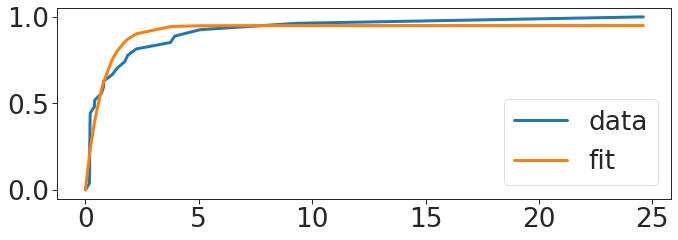

In [154]:
plt.figure(figsize=(11, 3.5))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax.plot(times, ylabels, label="data", linewidth=3)
ax.plot(times, func_exp(np.asarray(times), *popt), label="fit", linewidth=3)

ax.legend()
print(integr.quad(pdf, 0, times[-1], args=(popt[0], popt[1]))[0])
print(comp_mse(ylabels, func_exp(np.asarray(times), *popt)))